In [1]:
!pyenv global 3.6
!eval "$(pyenv init --path)"
!python3 --version

Python 3.6.4


In [2]:
PYENV_VERSION=3.6
!python3 -m venv venv36

In [3]:
!python3 --version

Python 3.6.4


In [4]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [5]:
!pip install spacy_udpipe

In [6]:
import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset

In [7]:
#подготовка признаков

In [8]:
import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w\d]+')


def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]


def character_tokenize(txt):
    return list(txt)


def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]


def add_fake_token(word2id, token=''):
    word2id_new = {token: i + 1 for token, i in word2id.items()}
    word2id_new[token] = 0
    return word2id_new


def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


PAD_TOKEN = '__PAD__'
NUMERIC_TOKEN = '__NUMBER__'
NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)


def replace_number_nokens(tokenized_texts):
    return [[token if not NUMERIC_RE.match(token) else NUMERIC_TOKEN for token in text]
            for text in tokenized_texts]

In [9]:
import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()


class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label

In [10]:
import pandas as pd
df = pd.read_csv("data/telegram/bitkogan.csv")

In [11]:
pnl = pd.read_csv('data/pnl/Backtest_EURUSD_5_days.txt')
pnl['date_start'] = pd.to_datetime(pnl['date_start']).dt.strftime('%Y-%m-%d')
pnl['pnl_sign'] = pnl['pnl'].apply(lambda x: 1 if x >= 0 else 0)
pnl

,date_start,pnl,pnl_sign
0,2022-03-02,-8967.190672,0
1,2022-03-03,-12548.743088,0
2,2022-03-04,-15486.634276,0
3,2022-03-09,12709.989084,1
4,2022-03-10,4612.031243,1
...,...,...,...
91,2022-10-18,1318.776018,1
92,2022-10-19,-1381.633241,0
93,2022-10-20,-898.408314,0
94,2022-10-21,675.094148,1


In [12]:
pnl['pnl_sign'].sum() / pnl.shape[0]

0.4791666666666667

In [13]:
pnl['cumm_text'] = None
pnl

,date_start,pnl,pnl_sign,cumm_text
0,2022-03-02,-8967.190672,0,None
1,2022-03-03,-12548.743088,0,None
2,2022-03-04,-15486.634276,0,None
3,2022-03-09,12709.989084,1,None
4,2022-03-10,4612.031243,1,None
...,...,...,...,...
91,2022-10-18,1318.776018,1,None
92,2022-10-19,-1381.633241,0,None
93,2022-10-20,-898.408314,0,None
94,2022-10-21,675.094148,1,None


In [14]:
df_with_pnl = df[(df['date'] >= '2022-03-02') & (df['date'] <= '2022-11-01')]
df_with_pnl

,id,date,text
10792,16670,2022-03-02T09:14:20,"Доброе утро, друзья . Смешными сегодня выглядя..."
10793,16671,2022-03-02T10:25:22,Друзья! События в мире разворачиваются с такой...
10794,16672,2022-03-02T11:26:38,Сейчас мы наблюдаем огромные дисбалансы на рын...
10795,16673,2022-03-02T11:30:29,"Друзья, внеочередной эфир с Дмитрием Абзаловым..."
10796,16674,2022-03-02T13:10:13,«Северсталь»: стальной занавес «Северсталь» (...
...,...,...,...
12894,19462,2022-10-31T15:00:40,Казахстан: лавировать или не вылавировать? Н...
12895,19463,2022-10-31T16:01:07,📺 Релокация в Дубай: преимущества для бизнеса...
12896,19464,2022-10-31T17:00:15,Рекордное снижение электропотребления Это важ...
12897,19465,2022-10-31T18:20:53,К нам в личку часто обращаются на тему переезд...


In [49]:
i = 0
texts = ''
for _,row in df.iterrows():
    if i >= pnl.shape[0]:
        break

    if row['date'] <= pnl['date_start'][i]:
        texts += ' ' + row['text']
    else:
        pnl.at[i,'cumm_text'] = texts
        texts = ''
        i += 1
        continue

In [50]:
pnl

,date_start,pnl,pnl_sign,cumm_text
0,2022-03-02,-8967.190672,0,из российских биржевых идеек я бы посмотрел с...
1,2022-03-03,-12548.743088,0,Друзья! События в мире разворачиваются с тако...
2,2022-03-04,-15486.634276,0,"Fitch. Что за диверсия? В Fitch опасаются ,..."
3,2022-03-09,12709.989084,1,Как все вышеперечисленное влияет на жизнь кон...
4,2022-03-10,4612.031243,1,Дорогая российская власть!\n(В свете последни...
...,...,...,...,...
91,2022-10-18,1318.776018,1,Курс доллара относительно:\n1. Китайского юан...
92,2022-10-19,-1381.633241,0,График индекса DXY @bitkogan Доходность 10-...
93,2022-10-20,-898.408314,0,На рынках продолжается фиеста Великобритании...
94,2022-10-21,675.094148,1,А теперь о рынках. Что интересного там?▪️Инде...


In [51]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(pnl)

In [52]:
train_tokenized = tokenize_corpus(train['cumm_text'])
val_tokenized = tokenize_corpus(val['cumm_text'])

In [53]:
print(' '.join(train_tokenized[0]))

дорогая российская власть свете последних событий правда очень дешевая хотите знать теперь наладить речь геополитике ясно речь экономике если действительно хотите выдернуть самолет экономики крутого пике причём немедленно надо делать нужны серьезные структурные реформы всех сферах экономики бизнеса медицины образования нужно немедленно убирать регуляции давала дышать бизнесу особенно малому сейчас регуляция дикая безработица новые рабочие места выбирайте нужно полностью отменять закон киках вытащить сейчас рубеж бизнеса равно нереально если отмените эффект будет серьезный какой поговорим этом позже нужно полностью либерализовать закон землях сельскохозяйственного назначения нужно провести масштабную амнистию осуждён статье многие этих людей мозги нужны сейчас стране люди раньше схематозили сейчас всей стране схематозить придется будете шоке придумают запад обалдеет людей просто выпустить нужно поддержать судимость например снять нужно срочно хоть года временно менять налоговый кодекс м

In [54]:
# строим словарь - vocabulary с помощью функции build_vocabulary
# принимает на вход список списков токенезированные
# word_doc_freq - содержит относительные частоты всех слов в датасете, он понадобиться 
# на этапе формирования матрицы признаков

MAX_DF = 0.8 #во скольких документах встречаеться слово
MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 6745
[('стоит', 0), ('дальше', 1), ('хотя', 2), ('роста', 3), ('2022', 4), ('друзья', 5), ('через', 6), ('других', 7), ('вполне', 8), ('году', 9)]


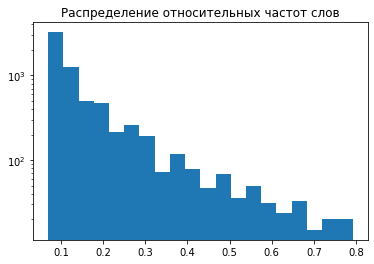

In [55]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [56]:
VECTORIZATION_MODE = 'tfidf'
# построение матрицы признаков по методу мешка слов
# функция vectorize_texts принимает на вход
#1. токенизированные список списков
#2. словарь
#3. вектор частоты токенизированны
#4. алгоритм взвешивания токенов по частоте mode - есть 4 алгорима - bin,tf,idf,tfidf
#5. флаг чтобы перемаштабировать флаг после взвешивания

train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()


Размерность матрицы признаков обучающей выборки (72, 6745)

Количество ненулевых элементов в обучающей выборке 76157
Процент заполненности матрицы признаков 15.68%



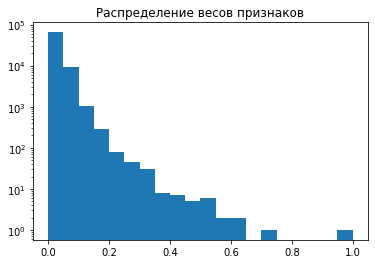

In [57]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [ ]:
#word2vec

In [58]:
from gensim.models import Word2Vec

In [ ]:
train_vectors

In [72]:
import gensim.downloader as api
for k, v in api.info().items():
    for k1, v1 in v.items():
        print(k1)

semeval-2016-2017-task3-subtaskBC
semeval-2016-2017-task3-subtaskA-unannotated
patent-2017
quora-duplicate-questions
wiki-english-20171001
text8
fake-news
20-newsgroups
__testing_matrix-synopsis
__testing_multipart-matrix-synopsis
fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [31]:
model_t1 = api.load('glove-twitter-200')

In [32]:
model_t = api.load('glove-twitter-100')

In [75]:
from gensim import utils

def get_vectors_gt100(row):
    '''
      word_doc_freq # частоты слов
      train_tokenized #сами слова
    '''
    vecs = [np.zeros(100)]
    for word in row:
        #print(row)
        try: 
            # если слово есть в нашем очищенном словаре
            # умножаем вектор на вес tfidf
            v = model_t[word] * word_doc_freq[vocabulary[word]] 
        except:
            v = np.zeros(100)
        vecs.append(v)
    return np.sum(np.array(vecs),axis=0)

In [76]:
train_vectors_gt100 = np.array([get_vectors_gt100(i) for i in train_tokenized])
val_vectors_gt100 = np.array([get_vectors_gt100(i) for i in val_tokenized])

In [62]:
train_vectors_gt100

array([[  88.72203816,  -90.68861817, -138.26727391, ..., -295.50371037,
          75.01878725,  -18.01799972],
       [ 182.25893834, -157.38130442, -275.49917696, ..., -529.40330707,
         137.72645055,   27.20742855],
       [  93.56910963,  -89.82073952, -138.0183647 , ..., -247.51753827,
          53.94656142,   -2.87843406],
       ...,
       [ 115.07815081, -105.92488673, -164.04234692, ..., -245.41957057,
          42.27196267,   10.15707883],
       [  72.99967488,  -93.38118077, -138.10010872, ..., -292.07150283,
          56.68907318,   -4.68621662],
       [  76.48529042,  -72.37141518, -110.66407164, ..., -197.01108283,
          52.83639641,   19.61475451]])

In [63]:
model_t1.most_similar(positive=['инвестор', 'рынок'], topn=1)

[('российский', 0.5974039435386658)]

In [64]:
model_t.most_similar(positive=['инвестор', 'рынок'], topn=1)

[('аналитик', 0.7176759243011475)]

In [65]:
y_train = train['pnl_sign']
X_train = train_vectors_gt100

y_val = val['pnl_sign']
X_val = val_vectors_gt100

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.5